# Exercise 7) Learning and Planning

In this exercise, we will again investigate the inverted pendulum from the `gym` environment. We want to check, which benefits the implementation of planning offers.

Please note that the parameter $n$ has a different meaning in the context of planning (number of planning steps per actual step) than in the context of n-step learning.

In [1]:
import numpy as np
import gym
gym.logger.set_level(40)
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

We will reuse the discretization routine from the previous exercise:

In [2]:
d_T = 15
d_theta = 15
d_omega = 15

def discretize_state(states):   
    limits = [1, 1, 8]
    nb_disc_intervals = [d_theta, d_theta, d_omega]
    
    # bring to value range [-1, 1]
    norm_states = [state / limit for state, limit in zip(states, limits)]
    interval_lengths = [2 / d for d in nb_disc_intervals]
    disc_state = [(norm_state + 1) // interval_length for norm_state, interval_length in zip(norm_states, interval_lengths)]
    disc_state = [(state - 1) if state == d else state for state, d in zip(disc_state, nb_disc_intervals)] # ensure that disc_state < d
    
    return np.array(disc_state)
    

    
    
def continualize_action(disc_action):    
    limit = 2
    interval_length = 2 / (d_T-1)
    norm_action = disc_action * interval_length
    cont_action = (norm_action - 1) * limit
    return np.array(cont_action).flatten()

## 1) Dyna-Q

Write a Dyna-Q algorithm to solve the inverted pendulum. Check the quality of the result for different number of episodes, number of steps per episode and number of planning steps per interaction.

Make sure that the total number of learning steps stays the same for different n, such that comparisons are fair:

$\text{episodes} \cdot \text{steps} \cdot (1+n) = \text{const.}$

Interesting metrics for a comparison could be e.g. the execution time (the tqdm loading bar shows execution time of loops, alternatively you can use the time.time() command to get the momentary system time in seconds) and training stability. 

![](DynaQ_Algo.png)

## Solution 1)

The solution code is given below.


In [3]:
def pendulumDynaQ(alpha, gamma, epsilon, n, nb_episodes, nb_steps):

    env = gym.make('Pendulum-v0')
    env = env.unwrapped

    action_values = np.zeros([d_theta, d_theta, d_omega, d_T])
    pi = np.zeros([d_theta, d_theta, d_omega])

    model = {} # dictionary

    cumulative_reward_history = [] # we can use this to figure out how well the learning worked

    for j in tqdm(range(nb_episodes), position=0, leave=True):
        
        ### BEGIN SOLUTION

        rewards = [] # this time, this list is only for monitoring

        state = env.reset() # initialize x_0
        state = tuple(discretize_state(state).astype(int))

        for k in range(nb_steps):

            # sample experiences for the model
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice(d_T) # explorative action
            else:
                action = pi[state].astype(int) # exploitative action        

            cont_action = continualize_action(action)
            next_state, reward, done, _ = env.step(cont_action)
            next_state = tuple(discretize_state(next_state).astype(int))

            # learn from the momentary experience
            action_values[state][action] += alpha * (reward 
                                                          + gamma * np.max(action_values[next_state])
                                                          - action_values[state][action]
                                                         )
            pi[state] = np.argmax(action_values[state])
            model[state, action] = (next_state, reward) # update the model accoring to the latest experience
            state = next_state

            rewards.append(reward)     


            # learn from the model, IMPORTANT: USE DIFFERENT VARIABLES HERE
            for i in range(n):
                # sample a random key from the dict: this state action combination has surely been taken in the past
                x, u = random.sample(model.keys(), 1)[0]
                x_1, r = model[x, u]
                action_values[x][u] += alpha * (r 
                                                + gamma * np.max(action_values[x_1])
                                                - action_values[x][u]
                                               )
                pi[x] = np.argmax(action_values[x])

            if done:
                break
                

        cumulative_reward_history.append(np.sum(rewards))

    env.close()
    
    ### END SOLUTION
    
    return cumulative_reward_history, pi



Function to evaluate and render the measurement using the gym environment:

In [15]:
def experiment(pi,nb_steps = 300):
# Runs the inverted pendulum experiment using policy pi for nb_steps steps


    env = gym.make('Pendulum-v0')
    env = env.unwrapped


    state = env.reset() # initialize x_0
    disc_state = tuple(discretize_state(state).astype(int)) # only tuples of integers can be used as index 
    disc_action = pi[disc_state].astype(int)

    for k in range(nb_steps):

        cont_action = continualize_action(disc_action)
        env.render() # comment out for faster execution
        state, reward, done, _ = env.step(cont_action)
        disc_state = tuple(discretize_state(state).astype(int))

        if done:
            break

        disc_action = pi[disc_state].astype(int) # exploitative action

    env.close()

Let's use nb_episodes = 5000, nb_steps = 500, n = 0 as a first try. This is effectively Q learning.

\begin{align}
5000 \cdot 500 \cdot (0+1) &= 2.5 \cdot 10^6
\end{align}

The resulting policy is satisfactory.



In [119]:
### train 
print("Run without planning")
no_planning_history, no_planning_pi = pendulumDynaQ(alpha = 0.1, gamma = 0.9, epsilon = 0.1, n = 0, nb_episodes = 5000, nb_steps = 500)

Run without planning


In [132]:
### run and render the experiment
experiment(no_planning_pi,nb_steps = 300)

Now let's try $n=9$ with the same nb_steps = 500:

\begin{align}
\text{nb_episodes} &= \frac{2.5 \cdot 10^6}{500 \cdot (9+1)} = 500
\end{align}

The resulting policy also looks good.



In [120]:
### train
print("Run with planning")
with_planning_history, with_planning_pi = pendulumDynaQ(alpha = 0.1, gamma = 0.9, epsilon = 0.1, n = 9, nb_episodes = 500, nb_steps = 500)

Run with planning


In [137]:
### run and render the experiment
experiment(with_planning_pi,nb_steps = 300)

Now lets compare the cumulative rewards:


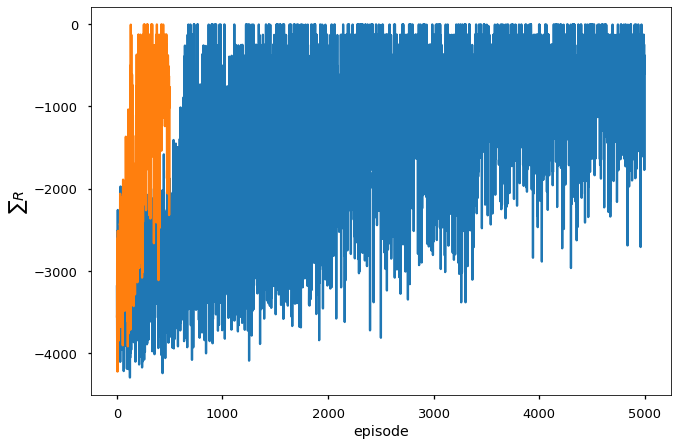

In [122]:
plt.plot(no_planning_history)
plt.plot(with_planning_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.show()


The cumulative reward over the episodes both seems to have high variance.

So why should we prefer the planning method?
### Planning leads to the agent interacting less often with the "real" environment, such that in the end fewer interaction time is needed.

## 2) Simulation-based planning

Although it can be useful for small state spaces, building a system model by storing large amounts of state transitions like in task (1) is rarely feasible in engineering. As engineers, we are capable of a more efficient way of system modeling that we can utilize here: differential equations.

Using a state-space model allows to efficiently integrate existing pre-knowledge into the Dyna-Q algorithm we already used. To do so, write a class `pendulum_model` that implements a model of the pendulum. This class should work similar to `gym`: it should at least have a `step` and a `reset` method. In the step method, make use of forward Euler integration to simulate the system dynamics. In the reset method, allow to pass an optional initial state to the model, such that we can easily compare model and environment. If no initial state is passed to the `reset` function, a random initial state should be determined.

Integrate this model into a Dyna-Q algorithm.

Model of the pendulum in differential-equation form for change of the angular frequency $\omega$ and the angle $\theta$ depending on the torque $T_\mathrm{u}$:

\begin{align}
\dot{\omega} &= -\frac{3 g}{2 l} \text{sin}(\theta +\pi) + \frac{1}{J} T_\mathrm{u}
\\
\dot{\theta} &= \omega
\end{align}



Parameters (gravity constant $g$, mass $m$, length  $l$ and intertia $J$ of the pendulum):

\begin{align}
g&=10 \, \frac{\text{m}}{\text{s}^2}
&
m&=1 \, \text{kg}
&
l&=1 \, \text{m}
&
J&=\frac{1}{3} m l^2
\end{align}

Forward Euler integration:

\begin{align}
\dot{x}(k T_S) \approx \frac{x[k+1] - x[k]}{T_S}
\end{align}

with sampling time $T_S = 0.05 \, \text{s}$

Reward function:

\begin{align}
r_{k+1} = -(\theta^2[k] + 0.1 \, \text{s}^2 \cdot \omega^2[k] + 0.001 \frac{1}{(\text{N}\text{m})^2} \cdot T_\mathrm{u}^2[k])
\end{align}

Limitations of state and action space:
\begin{align}
\theta &\in [-\pi, \pi]
&
\omega &\in [-8  \, \frac{1}{\text{s}}, 8  \, \frac{1}{\text{s}}]
&
T_\mathrm{u} &\in [-2 \, \text{N}\text{m}, 2 \, \text{N}\text{m}]
\end{align}

And of course input and output space:
\begin{align}
\text{action}&=T_\mathrm{u}
&
\text{state}&=
\begin{bmatrix}
\text{cos}(\theta)\\
\text{sin}(\theta)\\
\omega
\end{bmatrix}
\end{align}

## Solution 2)

Model-based planning does not necessarily run faster than experience-based planning. However, experience-based planning fails to cover the whole state space especially in the earlier episodes when there are too few experiences. On the other hand, model-based planning can, of course, only be performed if a state-space model with accurate parametrization is available. In order to overcome parametric deviations between state-space model and environment, one could even use the measurements from the actual environment in order to identify the parameters of the model during runtime.

In [66]:

class pendulum_model:
    def __init__(self, dt=0.05, m=1, g=10, l=1):
        
        ### BEGIN SOLUTION
        
        self.max_speed  = 8
        self.max_torque = 2

        self.dt = dt # sampling time in s
        self.g  =  g # gravity in m / s^2
        self.m  =  m # mass in kg
        self.l  =  l # length in m
        
        self.J = 1 / 3 * m * l ** 2 # pedulums moment of inertia in kg * m^2
        
        ### END SOLUTION
    
    def reset(self, state=None):
        
        ### BEGIN SOLUTION
        
        # if no state is give, set randomly
        if np.any(state == None):
            self.theta = np.random.uniform(-np.pi, +np.pi)
            self.omega = np.random.uniform(-self.max_speed, +self.max_speed)
                        
        # else set initial state as given    
        else:
            self.theta = np.arctan2(state[1], state[0])
            self.omega = state[2]
            
        state = np.array([np.cos(self.theta), np.sin(self.theta), self.omega])
        
        ### END SOLUTION
        
        return state
    
    def step(self, T_u):
        
        ### BEGIN SOLUTION
        
        T_u = np.clip(T_u, -self.max_torque, +self.max_torque)[0]
        
        reward = -(self.angle_normalize(self.theta)** 2 + 0.1 * self.omega ** 2 + 0.001 * (T_u ** 2))
        
        # differential-equations for state values
        self.omega = self.omega + self.dt * (-3 * self.g/(2 * self.l) * np.sin(self.theta + np.pi) + 1 / self.J * T_u)
        self.theta = self.theta + self.dt * self.omega
        
        self.omega = np.clip(self.omega, -self.max_speed, +self.max_speed)
                
        state = np.array([np.cos(self.theta), np.sin(self.theta), self.omega])
        
        ### END SOLUTION
        
        return state, reward
    
    def angle_normalize(self, theta):
        # usage of this helper function is optional
        return (((theta+np.pi) % (2*np.pi)) - np.pi)

The following cell is for debugging of the `pendulum_model` class. 

In [44]:
env = gym.make('Pendulum-v0')
env = env.unwrapped # removes a builtin time limit of k_T = 200, we want to determine the time limit ourselves

model = pendulum_model()

state = env.reset()
print(state)
m_state = model.reset(state) # model is set to state of env

for _ in range(10000):    
    print(f"state: {state}")
    print(f"model: {m_state}")
    print()
    
    action = env.action_space.sample()
    
    state, reward, done, _ = env.step(action) # take action on env
    m_state, m_reward = model.step(action) # take the same action on model
    
    print(f"reward difference: {reward- m_reward}, env_reward:{reward}, model_reward:{m_reward}")
    
env.close()

[ 0.04729206 -0.9988811  -0.48690693]
state: [ 0.04729206 -0.9988811  -0.48690693]
model: [ 0.04729206 -0.9988811  -0.48690693]

reward difference: 0.0, env_reward:-2.347137870403856, model_reward:-2.347137870403856
state: [-0.02615445 -0.99965791 -1.46934266]
model: [-0.0150763  -0.99988635 -1.2477315 ]

reward difference: -0.09548089253936443, env_reward:-2.7685024582029105, model_reward:-2.673021565663546
state: [-0.12529803 -0.99211915 -1.98941596]
model: [-0.11413574 -0.99346516 -1.98616275]

reward difference: -0.03931346760092058, env_reward:-3.275556891403601, model_reward:-3.2362434238026805
state: [-0.26933651 -0.96304613 -2.94151574]
model: [-0.24882617 -0.96854816 -2.74166215]

reward difference: -0.19142615552259734, env_reward:-4.2672246797117035, model_reward:-4.075798524189106
state: [-0.42766097 -0.90393921 -3.38399161]
model: [-0.41156654 -0.91137972 -3.45408283]

reward difference: -0.023132419701973994, env_reward:-5.196133355529123, model_reward:-5.173000935827149


state: [-0.80519406 -0.5930114  -6.38471613]
model: [-0.45182633  0.89210592  3.6849115 ]

reward difference: -4.842643742133546, env_reward:-10.360877211786855, model_reward:-5.518233469653309
state: [-0.95860905 -0.28472565 -6.92146926]
model: [-0.63366456  0.77360792  4.34939121]

reward difference: -5.94343608835989, env_reward:-12.929602238754804, model_reward:-6.986166150394913
state: [-0.99779656  0.06634781 -7.1023362 ]
model: [-0.80331611  0.59555288  4.93123102]

reward difference: -5.8012369459357185, env_reward:-14.502651718474652, model_reward:-8.701414772538934
state: [-0.90970637  0.41525212 -7.23646678]
model: [-0.9325013   0.36116663  5.36870111]

reward difference: -2.0323473476725624, env_reward:-12.599362222751258, model_reward:-10.567014875078696
state: [-0.71179178  0.70239053 -7.01061   ]
model: [-0.9961521   0.08764123  5.63529697]

reward difference: 2.0037001811462876, env_reward:-10.50015485487303, model_reward:-12.503855036019317
state: [-0.44086718  0.89757

model: [-0.53517927 -0.84473851  4.61248672]

reward difference: -5.115087126532958, env_reward:-11.803028654022851, model_reward:-6.687941527489893
state: [-0.98971223 -0.14307234 -7.37396118]
model: [-0.35770365 -0.93383516  3.97824546]

reward difference: -9.092621408490999, env_reward:-14.427462832902052, model_reward:-5.334841424411053
state: [-0.97577928  0.2187574  -7.28211695]
model: [-0.20005725 -0.97978421  3.28782652]

reward difference: -9.613748290656865, env_reward:-13.83629947685449, model_reward:-4.222551186197626
state: [-0.83465575  0.55077198 -7.25496027]
model: [-0.07404139 -0.99725517  2.54614279]

reward difference: -8.45436461229879, env_reward:-11.812292639896736, model_reward:-3.3579280275979473
state: [-0.589586    0.80770561 -7.13922558]
model: [ 0.01505693 -0.99988664  1.7833342 ]

reward difference: -7.204411664019491, env_reward:-9.944037754960648, model_reward:-2.739626090941157
state: [-0.30728778  0.95161664 -6.36409181]
model: [ 0.06710139 -0.99774616 

reward difference: 0.37822805489249056, env_reward:-4.441983362243734, model_reward:-4.820211417136225
state: [ 0.66740828  0.74469201 -4.92985563]
model: [-0.53636537 -0.84398589 -3.9454437 ]

reward difference: 2.9870132817662594, env_reward:-3.1364410874702635, model_reward:-6.123454369236523
state: [ 0.81565138  0.57854372 -4.46262246]
model: [-0.71405585 -0.70008874 -4.58299741]

reward difference: 5.3265604314223545, env_reward:-2.37419126719953, model_reward:-7.700751698621884
state: [ 0.9192182   0.39374853 -4.24472265]
model: [-0.86802851 -0.49651435 -5.11886436]

reward difference: 7.529681196446603, env_reward:-1.9686494374012309, model_reward:-9.498330633847834
state: [ 0.97580333  0.21865007 -3.68550288]
model: [-0.96997318 -0.2432119  -5.47805471]

reward difference: 9.980359752142538, env_reward:-1.4068831320295963, model_reward:-11.387242884172135
state: [ 0.99902139  0.04422974 -3.52373371]
model: [-0.99930246  0.03734423 -5.66057456]

reward difference: 11.59688734228

model: [8.98008266e-04 9.99999597e-01 1.28012983e+00]

reward difference: -3.2504252134895806, env_reward:-5.879449812644234, model_reward:-2.6290245991546533
state: [ 0.0221612  -0.99975441  4.3966767 ]
model: [-0.10015698  0.99497165  2.02446401]

reward difference: -1.1288491377539622, env_reward:-4.33135975534804, model_reward:-3.202510617594078
state: [ 0.20209732 -0.97936545  3.6267187 ]
model: [-0.23654606  0.97162028  2.76968564]

reward difference: 0.8569780499031738, env_reward:-3.184834140379545, model_reward:-4.041812190282719
state: [ 0.34004694 -0.94040847  2.86935706]
model: [-0.40197469  0.91565078  3.49725897]

reward difference: 2.840118559858123, env_reward:-2.321079874462206, model_reward:-5.161198434320329
state: [ 0.43970607 -0.89814173  2.16609146]
model: [-0.58337459  0.81220323  4.18409909]

reward difference: 4.8492817133532435, env_reward:-1.7136499580309614, model_reward:-6.562931671384205
state: [ 0.50387283 -0.86377785  1.45610327]
model: [-0.75943811  0.6

state: [-0.20284851 -0.97921013 -2.5203322 ]
model: [-0.02318806 -0.99973112 -1.06221304]

reward difference: -1.1324313203751397, env_reward:-3.79005195761247, model_reward:-2.65762063723733
state: [-0.37277661 -0.92792112 -3.55466981]
model: [-0.11429024 -0.9934474  -1.82700788]

reward difference: -1.9028232759001336, env_reward:-5.077115682656887, model_reward:-3.174292406756753
state: [-0.55782356 -0.82995956 -4.19523238]
model: [-0.24062213 -0.97061887 -2.56932452]

reward difference: -2.4866278041400753, env_reward:-6.436660050677701, model_reward:-3.9500322465376256
state: [-0.74015935 -0.67243151 -4.83092309]
model: [-0.39668639 -0.9179542  -3.29794972]

reward difference: -3.1105928388335284, env_reward:-8.11523278647629, model_reward:-5.004639947642761
state: [-0.89567805 -0.44470308 -5.53292605]
model: [-0.57099653 -0.82095247 -3.99629934]

reward difference: -3.904776447886084, env_reward:-10.248331583781361, model_reward:-6.3435551358952775
state: [-0.98694103 -0.16108198

reward difference: 2.112421859726645, env_reward:-4.005076446517162, model_reward:-6.117498306243807
state: [-0.46752468  0.88398002  1.88901881]
model: [-0.32933054  0.9442147  -3.55924491]

reward difference: 0.31188827674067543, env_reward:-4.589555926301418, model_reward:-4.901444203042093
state: [-0.57287492  0.81964281  2.47041201]
model: [-0.19164339  0.98146462 -2.85516347]

reward difference: -1.4406099511975294, env_reward:-5.36975737322226, model_reward:-3.9291474220247307
state: [-0.68173548  0.73159876  2.80246186]
model: [-0.08606972  0.99628912 -2.13319912]

reward difference: -2.9714761363417503, env_reward:-6.172109066123399, model_reward:-3.2006329297816487
state: [-0.79354499  0.60851159  3.32961093]
model: [-0.01682256  0.99985849 -1.38705978]

reward difference: -4.582904993839045, env_reward:-7.298773040500753, model_reward:-2.715868046661708
state: [-0.8880363   0.45977336  3.52887257]
model: [ 0.0156771   0.99987711 -0.65002202]

reward difference: -5.8807586557

reward difference: -0.417126498766379, env_reward:-3.5842611626136374, model_reward:-3.1671346638472584
state: [-0.33598073 -0.94186886 -2.45412848]
model: [ 0.02534346 -0.9996788   1.56211579]

reward difference: -1.6311005991987764, env_reward:-4.266164627688171, model_reward:-2.6350640284893942
state: [-0.46931609 -0.88303024 -2.9173963 ]
model: [ 0.06652269 -0.99778491  0.82451338]

reward difference: -2.7612143230698805, env_reward:-5.094816316329075, model_reward:-2.3336019932591943
state: [-0.60889351 -0.79325197 -3.32297715]
model: [ 0.07096262 -0.99747898  0.08900929]

reward difference: -3.8067813311581653, env_reward:-6.057078291211569, model_reward:-2.250296960053404
state: [-0.74953274 -0.66196727 -3.85381923]
model: [ 0.03821825 -0.99926942 -0.6558951 ]

reward difference: -4.9408657281233666, env_reward:-7.333138325554503, model_reward:-2.392272597431137
state: [-0.87724741 -0.48003853 -4.45483526]
model: [-0.03229554 -0.99947836 -1.41057419]

reward difference: -6.18998

reward difference: 1.1005241390036362, env_reward:-7.512815356021259, model_reward:-8.613339495024896
state: [-0.91749359  0.39775058  3.6754644 ]
model: [-0.5718149   0.82038267 -4.76138006]

reward difference: -1.8002677975619479, env_reward:-8.817905490235406, model_reward:-7.017637692673458
state: [-0.97710442  0.21276032  3.89329472]
model: [-0.39053305  0.92058891 -4.15011719]

reward difference: -4.473078074098957, env_reward:-10.084962606502993, model_reward:-5.611884532404035
state: [-0.99983535  0.01814577  3.92504658]
model: [-0.22593937  0.97414137 -3.46606643]

reward difference: -6.859817109781184, env_reward:-11.296793027489324, model_reward:-4.43697591770814
state: [-0.98475802 -0.17392998  3.85931698]
model: [-0.09081059  0.99586818 -2.73942735]

reward difference: -6.779378082265775, env_reward:-10.291350322226196, model_reward:-3.5119722399604205
state: [-0.93434695 -0.35636466  3.7911026 ]
model: [ 0.00853476  0.99996358 -1.98941456]

reward difference: -6.313750255

state: [-0.45790363 -0.88900184 -2.42449276]
model: [-0.52663074  0.85009415 -4.66845799]

reward difference: 1.9211964420081893, env_reward:-4.778872860150638, model_reward:-6.700069302158827
state: [-0.57845969 -0.81571097 -2.82406957]
model: [-0.34642352  0.93807822 -4.01752864]

reward difference: -0.2653310271438407, env_reward:-5.583686586339958, model_reward:-5.318355559196117
state: [-0.70603482 -0.70817712 -3.34088408]
model: [-0.18718408  0.98232486 -3.30922154]

reward difference: -2.471170688671773, env_reward:-6.660803221362236, model_reward:-4.189632532690463
state: [-0.82754194 -0.5614039  -3.81663425]
model: [-0.05977368  0.99821196 -2.56970877]

reward difference: -4.617082672226255, env_reward:-7.936482968800659, model_reward:-3.319400296574404
state: [-0.92830455 -0.37182074 -4.30223364]
model: [ 0.03139936  0.99950692 -1.82427713]

reward difference: -6.769435202778624, env_reward:-9.474292687664068, model_reward:-2.7048574848854443
state: [-0.98668527 -0.16264127 -

reward difference: 2.9705087280072835, env_reward:-5.641590465304242, model_reward:-8.612099193311526
state: [-0.70933898 -0.70486752 -3.62462434]
model: [-0.92784346 -0.37296985 -5.35838896]

reward difference: 3.605085860213485, env_reward:-6.8803900377076666, model_reward:-10.485475897921152
state: [-0.83863176 -0.54469879 -4.12412912]
model: [-0.99496668 -0.10020636 -5.63665905]

reward difference: 4.143242105081853, env_reward:-8.28328983422351, model_reward:-12.426531939305363
state: [-0.94105313 -0.33825879 -4.61927801]
model: [-0.98285661  0.18437157 -5.71614506]

reward difference: 2.051980452121935, env_reward:-9.954462947102972, model_reward:-12.006443399224906
state: [-0.99458565 -0.10392012 -4.81915854]
model: [-0.89418395  0.44769975 -5.57517571]

reward difference: -1.2720045958977444, env_reward:-11.552252378409449, model_reward:-10.280247782511704
state: [-0.99198507  0.12635512 -4.61603706]
model: [-0.74819522  0.66347864 -5.22534782]

reward difference: -2.6522653424

reward difference: 1.4586330295809735, env_reward:-1.2474159920144245, model_reward:-2.706049021595398
state: [ 0.5371725  -0.84347241 -2.9062825 ]
model: [ 0.12885641  0.99166326 -1.33191969]

reward difference: 0.40346409128731553, env_reward:-1.8553792479964115, model_reward:-2.258843339283727
state: [ 0.36770337 -0.92994313 -3.8108627 ]
model: [ 0.15863129  0.98733789 -0.60177104]

reward difference: -0.8499972569474403, env_reward:-2.8788437400417206, model_reward:-2.0288464830942803
state: [ 0.14632756 -0.98923619 -4.59366647]
model: [0.15198964 0.98838209 0.13446506]

reward difference: -2.1246436841974945, env_reward:-4.139049084933439, model_reward:-2.0144054007359444
state: [-0.12800001 -0.99177417 -5.50413957]
model: [0.10899778 0.99404199 0.86732433]

reward difference: -3.7052149521751887, env_reward:-5.9182758200411225, model_reward:-2.213060867865934
state: [-0.4352195  -0.90032438 -6.4385986 ]
model: [0.02904447 0.99957812 1.6033244 ]

reward difference: -5.596261950506

state: [ 0.74053228 -0.67202079  0.01484447]
model: [-0.55022069 -0.83501928 -4.24855648]

reward difference: 5.899167579603931, env_reward:-0.5455951988820763, model_reward:-6.444762778486008
state: [ 0.71564173 -0.69846755 -0.72639254]
model: [-0.7358781  -0.67711403 -4.88668201]

reward difference: 7.486527813753932, env_reward:-0.6506863424646435, model_reward:-8.137214156218576
state: [ 0.67053845 -0.74187478 -1.25216203]
model: [-0.88970257 -0.45654061 -5.39461348]

reward difference: 9.17023001267557, env_reward:-0.8567266007661009, model_reward:-10.02695661344167
state: [ 0.59402463 -0.80444685 -1.97763422]
model: [-0.98259809 -0.18574445 -5.74547224]

reward difference: 10.766821303793224, env_reward:-1.2654136101980125, model_reward:-12.032234913991235
state: [ 0.48062829 -0.87692442 -2.69363176]
model: [-0.9942069   0.10748321 -5.8904137 ]

reward difference: 10.805019455880515, env_reward:-1.870374432926389, model_reward:-12.675393888806905
state: [ 0.33519139 -0.94215006 -

model: [-0.49903925 -0.86657938  4.76711922]

reward difference: 1.0820914898565004, env_reward:-5.572301409845486, model_reward:-6.654392899701986
state: [ 0.34771997 -0.93759843  5.0855295 ]
model: [-0.31138812 -0.95028282  4.11672649]

reward difference: 1.1931246125047466, env_reward:-4.067224293653071, model_reward:-5.260348906157818
state: [ 0.53200575 -0.84674074  4.11658745]
model: [-0.14658695 -0.98919779  3.39072721]

reward difference: 1.3865462322432354, env_reward:-2.717989214495333, model_reward:-4.104535446738568
state: [ 0.68111627 -0.73217527  3.76637098]
model: [-0.01396307 -0.99990251  2.66307082]

reward difference: 1.1272243907352753, env_reward:-2.09379247584448, model_reward:-3.221016866579755
state: [ 0.7923421  -0.61007704  3.30704715]
model: [ 0.0818266  -0.99664658  1.91763432]

reward difference: 1.0602910618805605, env_reward:-1.52466943265166, model_reward:-2.5849604945322207
state: [ 0.86840167 -0.49586141  2.74662642]
model: [ 0.13970997 -0.99019247  1.1

reward difference: 8.002585576334205, env_reward:-0.8752439593891488, model_reward:-8.877829535723354
state: [ 0.62195713 -0.78305129 -2.04788208]
model: [-0.57753107 -0.8163687   4.94906522]

reward difference: 6.00151150574583, env_reward:-1.2313719498500508, model_reward:-7.232883455595881
state: [ 0.52439379 -0.85147587 -2.38473186]
model: [-0.38779265 -0.92174664  4.34931062]

reward difference: 4.1621027011372345, env_reward:-1.6097621431893268, model_reward:-5.771864844326561
state: [ 0.40236621 -0.9154788  -2.758059  ]
model: [-0.21302736 -0.97704623  3.67126463]

reward difference: 2.4370817543782106, env_reward:-2.098826396324572, model_reward:-4.535908150702783
state: [ 0.23633023 -0.9716728  -3.51025406]
model: [-0.06786018 -0.99769484  2.93520066]

reward difference: 0.5399373605634419, env_reward:-3.010018273540048, model_reward:-3.54995563410349
state: [ 0.01354012 -0.99990833 -4.50093639]
model: [ 0.04076799 -0.99916864  2.17383314]

reward difference: -1.63738127512541

state: [ 0.55657262 -0.83079897  1.32846205]
model: [-0.96920731 -0.24624618 -5.62702417]

reward difference: 10.396615919088227, env_reward:-1.1381541031675968, model_reward:-11.534770022255824
state: [ 0.58272485 -0.81266952  0.63645946]
model: [-0.99912013  0.04194013 -5.81515398]

reward difference: 12.048795816319561, env_reward:-0.9409338943348967, model_reward:-12.989729710654458
state: [ 0.58746054 -0.80925281  0.11679178]
model: [-0.94574616  0.32490644 -5.77920715]

reward difference: 10.349459754674331, env_reward:-0.8904105256683942, model_reward:-11.239870280342725
state: [ 0.56843908 -0.82272536 -0.46619747]
model: [-0.82100382  0.5709227  -5.53432981]

reward difference: 8.528595836351167, env_reward:-0.9559904581253228, model_reward:-9.48458629447649
state: [ 0.51757468 -0.85563804 -1.2118672 ]
model: [-0.64996516  0.75996401 -5.11256907]

reward difference: 6.603502043186657, env_reward:-1.2035677702189926, model_reward:-7.807069813405649
state: [ 0.42563027 -0.9048971

state: [-0.83422547  0.55142348 -4.78746993]
model: [ 0.10515411 -0.99445594  1.50805879]

reward difference: -6.457950469944407, env_reward:-8.83403538288645, model_reward:-2.3760849129420425
state: [-0.70041938  0.71373152 -4.21483552]
model: [ 0.14336171 -0.98967036  0.77017018]

reward difference: -5.1883951002633975, env_reward:-7.285371494910743, model_reward:-2.096976394647345
state: [-0.56564095  0.82465163 -3.49549265]
model: [ 0.14519827 -0.98940258  0.03711962]

reward difference: -3.9084603764052845, env_reward:-5.939508371627401, model_reward:-2.0310479952221163
state: [-0.44306632  0.89648884 -2.84388249]
model: [ 0.11032451 -0.99389562 -0.70327624]

reward difference: -2.7471251063011186, env_reward:-4.929299752999296, model_reward:-2.1821746466981775
state: [-0.33888465  0.94082793 -2.26570041]
model: [ 0.03787013 -0.99928267 -1.45340718]

reward difference: -1.6253431826454205, env_reward:-4.186417428285548, model_reward:-2.5610742456401274
state: [-0.26448427  0.96439

reward difference: 9.523501381913409, env_reward:-2.5421672109716886, model_reward:-12.065668592885098
state: [-0.01239499 -0.99992318 -2.68911932]
model: [-0.99347076 -0.11408704  5.87875799]

reward difference: 9.390630429607041, env_reward:-3.229722104833005, model_reward:-12.620352534440046
state: [-0.18551824 -0.98264082 -3.48407842]
model: [-0.91954191 -0.39299195  5.79094187]

reward difference: 6.546235080025806, env_reward:-4.302551465653146, model_reward:-10.848786545678951
state: [-0.38392119 -0.92336587 -4.1487991 ]
model: [-0.77828048 -0.62791679  5.49981091]

reward difference: 3.5079450101817127, env_reward:-5.584374066426095, model_reward:-9.092319076607808
state: [-0.58440568 -0.81146165 -4.60216535]
model: [-0.5971001  -0.80216674  5.04083122]

reward difference: 0.4923220007974063, env_reward:-6.938144407214745, model_reward:-7.430466408012151
state: [-0.76634391 -0.64243055 -4.97966369]
model: [-0.40533302 -0.9141691   4.45076107]

reward difference: -2.518858334828

reward difference: -0.6219432466918509, env_reward:-2.7640640336547317, model_reward:-2.142120786962881
state: [ 0.11630952  0.99321302 -1.2145633 ]
model: [ 0.05403753 -0.99853891 -1.27376946]

reward difference: 0.20044540012175238, env_reward:-2.2628475344607635, model_reward:-2.463292934582516
state: [ 0.13400572  0.99098056 -0.35673413]
model: [-0.04677045 -0.99890566 -2.01702766]

reward difference: 0.947486158969042, env_reward:-2.0767690048899037, model_reward:-3.0242551638589457
state: [0.10800986 0.99414982 0.52378188]
model: [-0.18370538 -0.98298135 -2.75934288]

reward difference: 1.6767951952904587, env_reward:-2.1671059369665593, model_reward:-3.843901132257018
state: [0.0502645  0.99873594 1.15870569]
model: [-0.35214351 -0.93594602 -3.50211332]

reward difference: 2.507702421113262, env_reward:-2.4462908818556497, model_reward:-4.953993302968912
state: [-0.04298897  0.99907555  1.86575818]
model: [-0.5397743  -0.84180978 -4.20617281]

reward difference: 3.40047027330396

state: [-0.38144133 -0.92439305  2.87308112]
model: [-0.94589549  0.32447144 -5.84353718]

reward difference: 6.641702097496687, env_reward:-4.676471596769888, model_reward:-11.318173694266575
state: [-0.27151139 -0.96243523  2.32783901]
model: [-0.81959535  0.57294281 -5.59278097]

reward difference: 5.587704631204009, env_reward:-3.9488367850536346, model_reward:-9.536541416257643
state: [-0.19082672 -0.98162374  1.65917575]
model: [-0.6462679   0.76311061 -5.1604157 ]

reward difference: 4.448947666466157, env_reward:-3.383921730707507, model_reward:-7.832869397173664
state: [-0.15335902 -0.98817054  0.76075325]
model: [-0.45544674  0.89026303 -4.59619298]

reward difference: 3.256405490774042, env_reward:-3.03272773460112, model_reward:-6.289133225375162
state: [-0.15079957 -0.98856436  0.05179135]
model: [-0.27301874  0.96200872 -3.92688741]

reward difference: 1.9885081608384505, env_reward:-2.969730092817491, model_reward:-4.958238253655941
state: [-0.19871908 -0.98005649 -0.973

reward difference: -2.924336497949002, env_reward:-5.047401782847142, model_reward:-2.1230652848981397
state: [-0.43155663 -0.90208585  1.89550025]
model: [ 0.0589059  -0.99826354 -1.45842659]

reward difference: -1.9292272117581986, env_reward:-4.427637528270292, model_reward:-2.4984103165120937
state: [-0.37580764 -0.92669769  1.21899022]
model: [-0.05139341 -0.99867849 -2.20712153]

reward difference: -0.8560703608606173, env_reward:-3.9747824207891704, model_reward:-3.118712059928553
state: [-0.35124865 -0.93628221  0.52727494]
model: [-0.19789924 -0.98022237 -2.95596499]

reward difference: 0.2551637845932597, env_reward:-3.7516172661619858, model_reward:-4.0067810507552455
state: [-0.3612821  -0.93245656 -0.2147621 ]
model: [-0.37451204 -0.92722205 -3.69312304]

reward difference: 1.4147229041392575, env_reward:-3.770924394583495, model_reward:-5.185647298722753
state: [-0.39660269 -0.91799036 -0.76341125]
model: [-0.56705063 -0.82368294 -4.38100491]

reward difference: 2.6711913

reward difference: 1.5122785176266715, env_reward:-3.920069915547046, model_reward:-5.4323484331737175
state: [-0.43903407 -0.89847041 -2.88866742]
model: [-0.15224277 -0.98834313  3.54217095]

reward difference: -0.7107498709573363, env_reward:-4.939047617069722, model_reward:-4.228297746112386
state: [-0.58132234 -0.81367336 -3.3165918 ]
model: [-0.0121763  -0.99992587  2.81321003]

reward difference: -2.603894687116772, env_reward:-5.9014020323163505, model_reward:-3.2975073451995787
state: [-0.73164163 -0.68168947 -4.0074824 ]
model: [ 0.09066043 -0.99588186  2.05923385]

reward difference: -4.710897775784678, env_reward:-7.326534490299441, model_reward:-2.6156367145147623
state: [-0.86977143 -0.49345482 -4.68023807]
model: [ 0.15536555 -0.98785705  1.30424802]

reward difference: -6.912136153629458, env_reward:-9.087552949400417, model_reward:-2.175416795770959
state: [-0.96910933 -0.24663154 -5.3370905 ]
model: [ 0.18242114 -0.98322049  0.54901717]

reward difference: -9.25949571

model: [-0.75859861 -0.65155825 -4.8085578 ]

reward difference: 5.538686247589725, env_reward:-2.691305413540128, model_reward:-8.229991661129853
state: [ 0.19852282  0.98009627 -1.86251713]
model: [-0.90300282 -0.42963461 -5.31097275]

reward difference: 7.87078453134615, env_reward:-2.226625719713926, model_reward:-10.097410251060076
state: [ 0.25695345  0.96642378 -1.20035925]
model: [-0.98686698 -0.161535   -5.63684443]

reward difference: 10.191290639352106, env_reward:-1.8626245519423221, model_reward:-12.053915191294427
state: [ 0.27927736  0.96021047 -0.46345939]
model: [-0.99211971  0.12529354 -5.75739158]

reward difference: 10.731032423860153, env_reward:-1.6811152148409134, model_reward:-12.412147638701066
state: [0.27523442 0.96137714 0.08415818]
model: [-0.91742902  0.39789947 -5.67204844]

reward difference: 9.013164109606164, env_reward:-1.6699347883764857, model_reward:-10.68309889798265
state: [0.23455159 0.97210367 0.84152538]
model: [-0.77894385  0.62709368 -5.3718

KeyboardInterrupt: 

Using $-\mathrm{sin}(\theta)$ instead of $\mathrm{sin}(\theta +\pi)$ makes no difference when assuming analytical precision, but due to numeric errors these formulations will still yield different results in numpy, mainly because $\pi$ is represented with finite (float) precision. In order to yield the same numbers as in `gym`, we will still make use of the (more cumbersome) $\mathrm{sin}(\theta +\pi)$.

Write a function for the Dyna-Q algorithm, which uses the model we defined above: 

In [67]:
def pendulumModelDynaQ(alpha, gamma, epsilon, n, nb_episodes, nb_steps):

    env = gym.make('Pendulum-v0')
    env = env.unwrapped
    model = pendulum_model()

    action_values = np.zeros([d_theta, d_theta, d_omega, d_T])
    pi = np.zeros([d_theta, d_theta, d_omega])

    cumulative_reward_history = [] # we can use this to figure out how well the learning worked

    for j in tqdm(range(nb_episodes), position=0, leave=True):
        
        ### BEGIN SOLUTION

        rewards = [] # this time, this list is only for monitoring

        state = env.reset() # initialize x_0
        state = tuple(discretize_state(state).astype(int))

        for k in range(nb_steps):

            # sample experiences for the model
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice(d_T) # explorative action
            else:
                action = pi[state].astype(int) # exploitative action        

            cont_action = continualize_action(action)
            next_state, reward, done, _ = env.step(cont_action)
            next_state = tuple(discretize_state(next_state).astype(int))

            # learn from the momentary experience
            action_values[state][action] += alpha * (reward 
                                                          + gamma * np.max(action_values[next_state])
                                                          - action_values[state][action]
                                                         )
            pi[state] = np.argmax(action_values[state])
            # no model update is needed
            state = next_state

            rewards.append(reward)     


            # learn from the model, IMPORTANT: USE DIFFERENT VARIABLES HERE
            for i in range(n):
                x = model.reset() # if no state is passed to the model, state is initialized randomly
                u_d = np.random.choice(d_T)
                                       
                x_d = tuple(discretize_state(x).astype(int))
                u = continualize_action(u_d)
                
                x_1, r = model.step(u)
                x_1_d = tuple(discretize_state(x_1).astype(int))
                action_values[x_d][u_d] += alpha * (r 
                                                    + gamma * np.max(action_values[x_1_d])
                                                    - action_values[x_d][u_d]
                                                    )
                pi[x_d] = np.argmax(action_values[x_d])

            if done:
                break
               

        cumulative_reward_history.append(np.sum(rewards))
       
    env.close()
    
    ### END SOLUTION
    
    return cumulative_reward_history, pi

Use the following cell to compare the learing from experience from 1) to the learning using the defined model: (Beware, nb_steps = 10000 can take some time)


Run with planning from experience



Run with planning from model


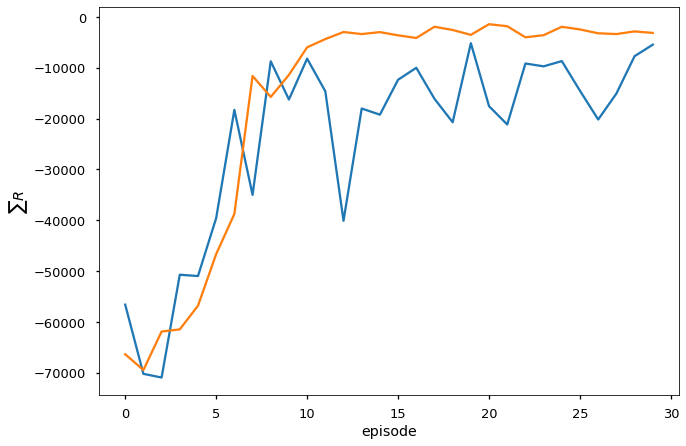

In [68]:
### train both setups once
print("Run with planning from experience")
exp_planning_history, exp_planning_pi = pendulumDynaQ(alpha = 0.1, gamma = 0.9, epsilon = 0.1, n = 19, nb_episodes = 30, nb_steps = 10000)

print("Run with planning from model")
model_planning_history, model_planning_pi = pendulumModelDynaQ(alpha = 0.1, gamma = 0.9, epsilon = 0.1, n = 19, nb_episodes = 30, nb_steps = 10000)
    


plt.plot(exp_planning_history)
plt.plot(model_planning_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.show()



Use the following cell to execute the policy we got using the model:

In [ ]:
experiment(model_planning_pi,nb_steps = 300)

### Extra-task:
Change the model parameters (e.g. $g$, $m$, $l$) so that our model differs from the "real world" (we got from gym).
What do you observe

By changing the parameters our model differs from the "real world". Depending on the amount of difference, the learing curve looks worse than the one with the correct values. 
The experiment result is also depending on the random starting position. 
Depending on the parameter difference, the experiment can not be executed successfully any more. 

Try to change the parameters on your own.

The Following learning curve results from a parameter change using $g =20 \, \frac{\text{m}}{\text{s}^2}, m = 5 \, \text{kg and } l = 2 \, \text{m}$:

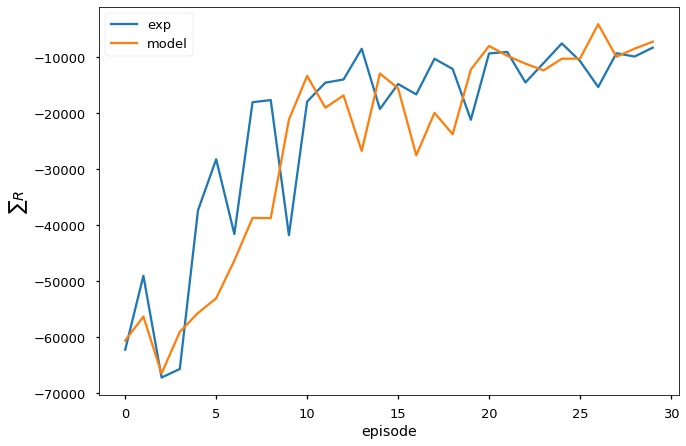

In [55]:
plt.plot(exp_planning_history, label="exp")
plt.plot(model_planning_history, label="model")
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.legend(loc="upper left")
plt.show()
